In [29]:
import import_ipynb 
import Simulation_For_Consesus_Protocol as sp
import random 
import matplotlib.pyplot as plt

In [31]:
def multicast(messages_timestamp,message,round_number,min_delay,max_delay):
    """Process p labels its current value with the current round number h, and then broadcasts
this labeled value to all processes, including itself.
    Futhermore it also generates a random delay for each message
"""
    for i in xrange(len(messages_timestamp)):
        delay = random.randint(min_delay,max_delay)
        messages_timestamp[i].insert(random.randint(0, len(messages_timestamp[i])), [message,delay,round_number]) 
        # The fact that I am inserting randomly is very important. If I would just append to the end of the list
        # the message of the first nodes would have priority over the message of the last nodes
    return messages_timestamp

In [32]:
def delete_node(i,length_messages,messages_timestamp,node_id):
    #Helper function to delete item from a list while iterating over it
    del(messages_timestamp[node_id][i])
    i-=1
    length_messages -=1
    return i,length_messages,messages_timestamp

In [33]:
def receive(messages_timestamp,node_id,round_number,messages_needed,debug=False):
    """Updates the given messages for a given node by either receiving the node if delay<0 
    and the round number in the timestamp is the same as the current round numbe. 
    It loops until it receives the amounts of messages needed.
    """
    message_for_node = messages_timestamp[node_id]
    if(debug):
        print("Messsages for node #{} :{}".format(node_id,message_for_node))
    messages_received = []
    while(True):
        length_messages = len(message_for_node)
        i = 0
        while i<length_messages:
            message_timestamp = message_for_node[i]
            if(message_timestamp[1]<=0 and message_timestamp[2]==round_number):
                messages_received.append(message_timestamp[0])
                i,length_messages,messages_timestamp = delete_node(i,length_messages,messages_timestamp,node_id)
            elif(message_timestamp[2]<round_number):
                i,length_messages,messages_timestamp = delete_node(i,length_messages,messages_timestamp,node_id)
            i+=1
            message_timestamp[1] -=1
            if(len(messages_received)==messages_needed):
                if debug:
                    print("Messsages received for node #{}: {}".format(node_id,messages_received))
                return messages_timestamp,messages_received

In [47]:
def update(nodes,node_id,messages_received,num_byzantine_nodes,debug=False):
    """Selects the kth (which is denoted by the parameter messages_to_select) smallest messages for node i
    and get their mean. It then makes the value of node i equal to that mean
    """
    sorted_messages = sorted(messages_received)
    messages_to_select = num_byzantine_nodes *2 +1 # The +1 because python slicing is not inclusive in the end
    messages_selected = sorted_messages[num_byzantine_nodes+1:messages_to_select+num_byzantine_nodes+1] # slicing from [f+1:3f+2] (because the it is not inclusive in the end)
    sum_received = sum(messages_selected)
    avg_message = sum_received/float(messages_to_select)
    if debug: 
        print "Sorted Messages: {}\nSelected Messages: {}".format(sorted_messages,messages_selected)
        print "Sum messages: {}".format(sum_received) 
        print "Amount of messages: {}".format(messages_to_select) 
        print "Avg of messages received {}".format(avg_message)
    nodes[node_id] = avg_message
    
    return nodes

In [35]:
def byzantine_random(messages_timestamp,nodes,round_number,min_input,max_input,min_delay,max_delay,debug=False):
    #Sends a random message to all nodes
    message =  random.uniform(min_input,max_input)
    if debug:
        print("Generating Byzantine message {} for all nodes".format(message))
    messages_timestamp = multicast(messages_timestamp,message,round_number,min_delay,max_delay)
    return messages_timestamp

In [36]:
def byzantine_sets(messages_timestamp,nodes,round_number,min_input,max_input,min_delay,max_delay,debug=False):
    message1 = max(nodes) 
    message2 = min(nodes)
    if debug:
        print("Generating Byzantine message {} for smaller set ".format(message1))
    if debug:
        print("Generating Byzantine message {} for bigger set".format(message2))
    pivot = nodes[0] #using the value of the first node as a pivot, note that the values of all nodes are random
    lower_set = [messages_timestamp[i] for i in range(len(messages_timestamp)) if nodes[i]<pivot]
    upper_set = [messages_timestamp[i] for i in range(len(messages_timestamp)) if nodes[i]>=pivot]
    if debug:
        print("Lower set before byzantine multicast: {}".format(lower_set))
        print("Upper set before byzantine multicast: {}".format(upper_set))
        print("Length of a timestamp before byzantine multicast: {}".format(len(messages_timestamp[len(messages_timestamp)-1])))
    multicast(lower_set,message1,round_number,min_delay,max_delay)
    multicast(upper_set,message2,round_number,min_delay,max_delay)
    if debug:
        print("Lower set after byzantine multicast: {}".format(lower_set))
        print("Upper set after byzantine multicast: {}".format(upper_set))
        print("Length of a timestamp after byzantine multicast: {}".format(len(messages_timestamp[len(messages_timestamp)-1])))
        
    if debug:
        print("Messages_timestamp after byzantine multicast: {}".format(messages_timestamp))
    return messages_timestamp

In [37]:
def simul_concensus_AO(min_delay,max_delay,max_input = 1,num_nodes=100, e=1,debug=False, byzantine_multicast = byzantine_random):
    num_byzantine_nodes = (num_nodes-1)/5 # N = 5f +1,therefore, f = (N-1)/5 #Also note that python use floor division
    messages_needed =num_nodes -num_byzantine_nodes # For this algorithm to work each node waits to receive N-f messages
    num_good_nodes = num_nodes - num_byzantine_nodes
    min_input = 0
    num_runs = 0
    """ We will only wait till the good nodes have converged, and we will only keep track of the messages for the good_nodes
    because the byzantine nodes send messages irrelevant to the value they receive. 
    Also note that byzantine nodes multicast exactly as good nodes for this simulation 
    (including sending a timestamp with round number and delay)  except for the fact that the byzantine nodes send faulty messages
    """
    good_nodes , messages_timestamp = sp.create_nodes_messages(min_input,max_input,num_good_nodes) 
    while not(sp.is_converged(good_nodes,e)):
        num_runs +=1
        for i in xrange(num_byzantine_nodes):
            messages_timestamp = byzantine_multicast(messages_timestamp,good_nodes,num_runs,min_input,max_input,min_delay,max_delay,debug=debug)
        for i in xrange(num_good_nodes):
            message = good_nodes[i]
            if debug:
                print("Generating message {} for all nodes".format(message))
            messages_timestamp = multicast(messages_timestamp,message,num_runs,min_delay,max_delay)
        for i in xrange(num_good_nodes):
            if debug:
                print "Previous value of  node # {}: {} : ".format(i,good_nodes[i])
            messages_timestamp,messages_received = receive(messages_timestamp,i,num_runs,messages_needed,debug=debug)
            good_nodes = update(good_nodes,i,messages_received, num_byzantine_nodes,debug=debug)
            if debug:
                print "Updated value of  node # {} :{} ".format(i,good_nodes[i])
    if debug:
        print("Final node values {}".format(good_nodes))
    return num_runs

In [38]:
#Adapter function for Byzantine sets
def simul_concensus_AO_byzantine_sets(min_delay,max_delay,max_input = 1,num_nodes=100, e=1,debug=False):
    return simul_concensus_AO(min_delay,max_delay,max_input = max_input, num_nodes = num_nodes, e=e,debug=debug, byzantine_multicast = byzantine_sets)

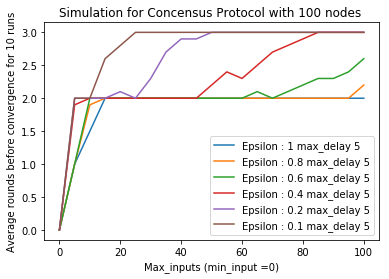

In [51]:
if __name__ == "__main__":
    epsilons = [1,.8,.6,.4,.2,.1]
    for e in epsilons:
        sp.plot_protocol(100,100,steps=5,e=e,simul_concensus_protocol=simul_concensus_AO)
    plt.legend(loc='best')
    plt.show()
    

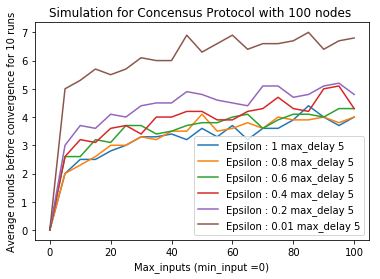

In [50]:
if __name__ == "__main__":
    epsilons = [1, 0.8, 0.6, 0.4, 0.2, 0.01]
    for e in epsilons:
        sp.plot_protocol(100,100,steps=5,e=e,simul_concensus_protocol=simul_concensus_AO_byzantine_sets)
    plt.legend(loc='best')
    plt.show()